In [1]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 23.2 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

In [3]:
import requests

url = "https://www.dropbox.com/scl/fi/wxc1jz8spd0thbzi4oj3h/mlp_data2.csv?rlkey=p0a22wgqlxdnxm7pum27lh86y&st=jelhn8kg&dl=1"

response = requests.get(url)

# Save the file locally
with open('mlp_data2.csv', 'wb') as file:
    file.write(response.content)

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_data_hist(df):
    # Define figure size and layout for subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15), dpi=80)

    # List of columns to plot histograms for
    columns = ['layers', 'all_parameters', 'activation_function', 'all_activations', 'batch_size', 'real_memory_usage', 'batch_norm_layer', 'dropout_layers']

    # Loop over the axes and columns to create histograms
    for ax, col in zip(axs.ravel(), columns):
        ax.hist(df[col], bins=200)
        ax.set_xlabel(col)
        ax.set_ylabel('count')

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()


      real_memory_usage  layers activation_function  batch_size  \
0                  1545       3                ReLU         996   
1                  1569       9            Softplus         939   
2                  1507      10                GELU         873   
3                  1457       4                Mish         518   
4                  4505      11                SELU         983   
...                 ...     ...                 ...         ...   
2995               1633       5               PReLU         254   
2996               1697      10                Tanh         135   
2997               1615       6               PReLU         575   
2998               1621       7                SiLU         140   
2999               1459       5                Mish         424   

      batch_norm_layer  dropout_layers  all_parameters  all_activations  \
0                    2               2         3560152             7430   
1                    0               8       

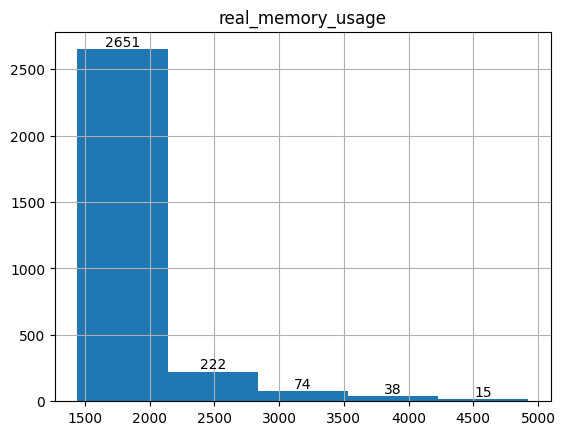

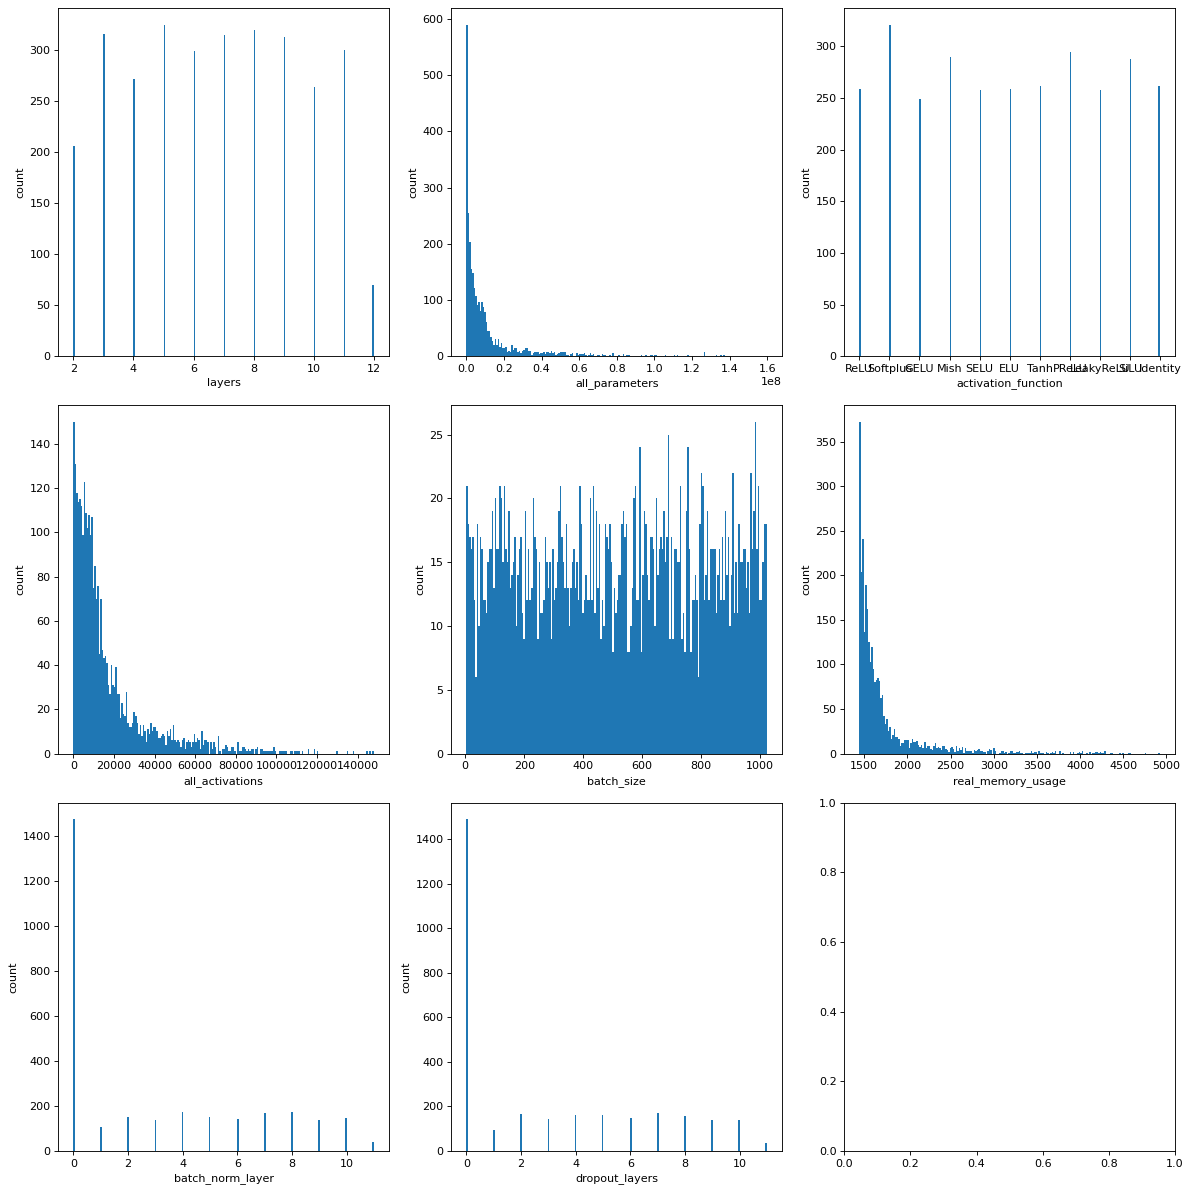

In [5]:
csv_file_path = "mlp_data2.csv"  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)


df = df[['Max GPU Memory (MiB)', 'Depth', 'Activation Function', 'Batch Size', 'Batch Normalization Layers', 'Dropout Layers', 'Total Parameters', 'Total Activations', 'Activations-Params', ]]

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',
    'Depth': 'layers',
    'Activation Function': 'activation_function',
    'Batch Size': 'batch_size',
    'Total Parameters': 'all_parameters',
    'Total Activations': 'all_activations',
    'Activations-Params': 'params_neurons_list',
    'Batch Normalization Layers': 'batch_norm_layer',
    'Dropout Layers': 'dropout_layers'
})

print(df)


columns_to_analyze = ['layers', 'all_parameters', 'activation_function', 'all_activations', 'batch_size', 'real_memory_usage', 'batch_norm_layer', 'dropout_layers']
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))

df[['real_memory_usage']].hist(bins=5)

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

plot_data_hist(df)

# One-hot coding for activations
Because this encoding increases the number of feature drastically is not a good way

In [ ]:
df_one_hot = pd.get_dummies(df['activation_function'], prefix='activation')

print(df_one_hot)


# saved_df = df

# Drop the original 'activation_function' column
# df = df.drop('activation_function', axis=1)

# # Concatenate the one-hot encoded columns back to the DataFrame
# df = pd.concat([df, df_one_hot], axis=1)

# print(df)

      activation_ELU  activation_GELU  activation_Identity  \
0              False            False                False   
1              False            False                False   
2              False             True                False   
3              False            False                False   
4              False            False                False   
...              ...              ...                  ...   
2995           False            False                False   
2996           False            False                False   
2997           False            False                False   
2998           False            False                False   
2999           False            False                False   

      activation_LeakyReLU  activation_Mish  activation_PReLU  \
0                    False            False             False   
1                    False            False             False   
2                    False            False             Fals

In [6]:
import numpy as np

# List of activation functions
activations = ['ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        # Map i to a position on the unit circle
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate 2D positional encodings for the number of activations
num_activations = len(activations)
positional_encodings = positional_encoding_2d(num_activations)

# Create a dictionary mapping activations to their positional encodings
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Print the result
for activation, encoding in activation_to_encoding.items():
    print(f"{activation}: {encoding}")

ELU: [0. 1.]
GELU: [0.28173256 0.95949297]
Identity: [0.54064082 0.84125353]
LeakyReLU: [0.75574957 0.65486073]
Mish: [0.909632   0.41541501]
PReLU: [0.98982144 0.14231484]
ReLU: [ 0.98982144 -0.14231484]
SELU: [ 0.909632   -0.41541501]
SiLU: [ 0.75574957 -0.65486073]
Softplus: [ 0.54064082 -0.84125353]
Tanh: [ 0.28173256 -0.95949297]


# having activations functions as two separate columns

In [7]:
# List of activation functions
activations = ['ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['activation_function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['activation_function'].map(lambda x: activation_to_encoding[x][1])

# Display the updated DataFrame
print(df)

      real_memory_usage  layers activation_function  batch_size  \
0                  1545       3                ReLU         996   
1                  1569       9            Softplus         939   
2                  1507      10                GELU         873   
3                  1457       4                Mish         518   
4                  4505      11                SELU         983   
...                 ...     ...                 ...         ...   
2995               1633       5               PReLU         254   
2996               1697      10                Tanh         135   
2997               1615       6               PReLU         575   
2998               1621       7                SiLU         140   
2999               1459       5                Mish         424   

      batch_norm_layer  dropout_layers  all_parameters  all_activations  \
0                    2               2         3560152             7430   
1                    0               8       

# filter the data


In [8]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [9]:
# in case wanna filter some of the data use this code

# df_filtered = df[df['layers'] <= 64]
# df_filtered = df_filtered[df_filtered['all_parameters'] <= 10e6]
# df_filtered = df_filtered[df_filtered['batch_size'] <= 64]
# df_filtered = df_filtered[df_filtered['all_activations'] <= 1e5]
# print(len(df_filtered))
# plot_data_hist(df_filtered)


In [10]:
class FC_base(nn.Module):
    def __init__(self, input_features=8, output_features=5, base_features=6):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)  # First layer (6 -> 64 units)
        self.bn1 = nn.BatchNorm1d(base_features)             # Batch Normalization after the first layer
        self.fc2 = nn.Linear(base_features, base_features)             # Second layer (64 -> 128 units)
        self.bn2 = nn.BatchNorm1d(base_features)            # Batch Normalization after the second layer
        self.fc3 = nn.Linear(base_features, base_features)             # Third layer (128 -> 64 units)
        self.bn3 = nn.BatchNorm1d(base_features)             # Batch Normalization after the third layer
        # self.fc4 = nn.Linear(base_features, base_features)             # Third layer (128 -> 64 units)
        # self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, output_features) # Output layer (64 -> 1 output for regression)
        self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        # Forward pass through the network
        x = self.relu(self.bn1(self.fc1(x)))
        # print(f"After fc1 shape: {x.shape}")
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        # print(f"After fc2 shape: {x.shape}")
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        # print(f"After fc3 shape: {x.shape}")
        # x = self.dropout(self.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)  # No activation function for the output layer in regression
        # print(f"Output shape: {x.shape}")
        return x

# classification

In [11]:
# df_normalized = df_filtered[['real_memory_usage', 'layers', 'batch_size', 'all_parameters', 'all_activations']]/df_filtered[['real_memory_usage', 'layers', 'batch_size', 'all_parameters', 'all_activations']].mean()

# no normalization
# df_normalized = df


# columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations']

# from sklearn.preprocessing import StandardScaler
# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler and transform the data
# df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
df_normalized = df


In [14]:
bins = [i*2000 for i in range(4)]  # Define your bin edges
print(bins)
bins.append(float('inf'))
labels = [i for i in range(len(bins)-1)]  # Labels corresponding to the bins

# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=True)

print(df, df['memory_usage_label'], "| length of labels", len(labels))

[0, 2000, 4000, 6000]
      real_memory_usage  layers activation_function  batch_size  \
0                  1545       3                ReLU         996   
1                  1569       9            Softplus         939   
2                  1507      10                GELU         873   
3                  1457       4                Mish         518   
4                  4505      11                SELU         983   
...                 ...     ...                 ...         ...   
2995               1633       5               PReLU         254   
2996               1697      10                Tanh         135   
2997               1615       6               PReLU         575   
2998               1621       7                SiLU         140   
2999               1459       5                Mish         424   

      batch_norm_layer  dropout_layers  all_parameters  all_activations  \
0                    2               2         3560152             7430   
1                    0 

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df_normalized[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

print(df_normalized)

total data size:  3000
train size 2100, val size: 594, test size: 306
      real_memory_usage  layers activation_function  batch_size  \
0                  1545       3                ReLU         996   
1                  1569       9            Softplus         939   
2                  1507      10                GELU         873   
3                  1457       4                Mish         518   
4                  4505      11                SELU         983   
...                 ...     ...                 ...         ...   
2995               1633       5               PReLU         254   
2996               1697      10                Tanh         135   
2997               1615       6               PReLU         575   
2998               1621       7                SiLU         140   
2999               1459       5                Mish         424   

      batch_norm_layer  dropout_layers  all_parameters  all_activations  \
0                    2               2         356

In [16]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 64, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 64, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([64, 8]), output shape: torch.Size([64])


In [17]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=8, output_features=output_size, base_features=7)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [18]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
classifier_model = classification_gpu_usage(output_size = len(labels))

classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(8,), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 7]              63
       BatchNorm1d-2                    [-1, 7]              14
              ReLU-3                    [-1, 7]               0
            Linear-4                    [-1, 7]              56
       BatchNorm1d-5                    [-1, 7]              14
              ReLU-6                    [-1, 7]               0
           Dropout-7                    [-1, 7]               0
            Linear-8                    [-1, 7]              56
       BatchNorm1d-9                    [-1, 7]              14
             ReLU-10                    [-1, 7]               0
          Dropout-11                    [-1, 7]               0
           Linear-12                    [-1, 4]              32
          FC_base-13                    [-1, 4]               0
Total params: 249
Trainable params: 249

In [19]:
# Initialize the history callback
history_callback = HistoryCallback()

classifier_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | FC_base          | 249    | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
249       Trainable params
0         Non-trainable params
249       Total params
0.001     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.471


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.462


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.417


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.374


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.354


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.328


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.314


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.285


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.267


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.247


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.223


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.215


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.189


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.170


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.131


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.115


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.092


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.075


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.059


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.026


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.021


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.002


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.993


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.955


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.941


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.917


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.908


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.898


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.876


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.871


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.862


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.852


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.844


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.822


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.813


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.780


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.759


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.757


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.734


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.728


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.716


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.697


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.669


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.643


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.622


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.620


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.610


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.589


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.553


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.544


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.517


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.509


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.499


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.487


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.481


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.472


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.462


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.454


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.438


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.427


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.412


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.396


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.384


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.370


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.361


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.348


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.341


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.340


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.332


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.309


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.305


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.296


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.292


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.286


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.285


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.277


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.269


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.256


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.254


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.245


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.241


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.241


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.240


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.232


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.222


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.215


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.212


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.203


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.198


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.188


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.185


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.177


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.177


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.169


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.161


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.155


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.152


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.145


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.140


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.137


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.135


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.133


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.129


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.120


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.120


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.116


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.112


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.108


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.108


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.104


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.101


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.100


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.094


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.091


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.091


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.089


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.083


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.082


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.081


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.081


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.080


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.079


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.075


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.071


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.070


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.069


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.069


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.067


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.067


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.066


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.065


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.063


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.062


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.061


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.059


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.057


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [20]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.9706
Precision: 0.9621
Recall: 0.9706
F1-Score: 0.9662

Confusion Matrix:
[[257   3   0]
 [  3  40   0]
 [  0   3   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       260
         1.0       0.87      0.93      0.90        43
         2.0       0.00      0.00      0.00         3

    accuracy                           0.97       306
   macro avg       0.62      0.64      0.63       306
weighted avg       0.96      0.97      0.97       306



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [22]:
from sklearn.manifold import TSNE

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']])


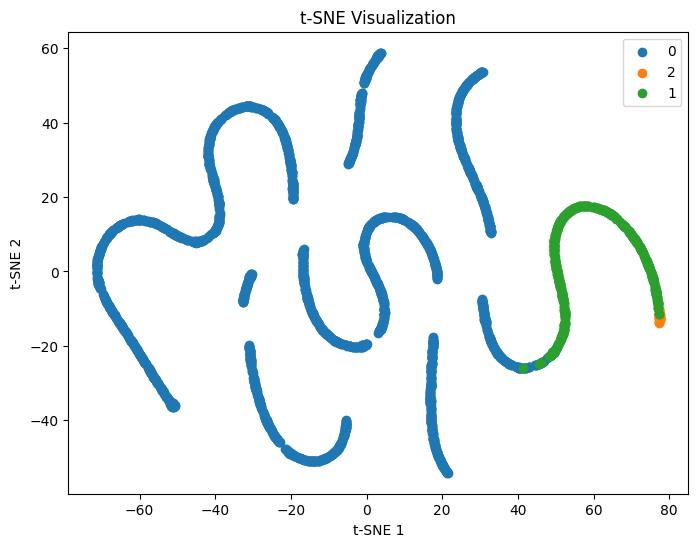

In [23]:
import matplotlib.pyplot as plt

# Create a new DataFrame for the t-SNE results
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results
plt.figure(figsize=(8, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=label)

plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


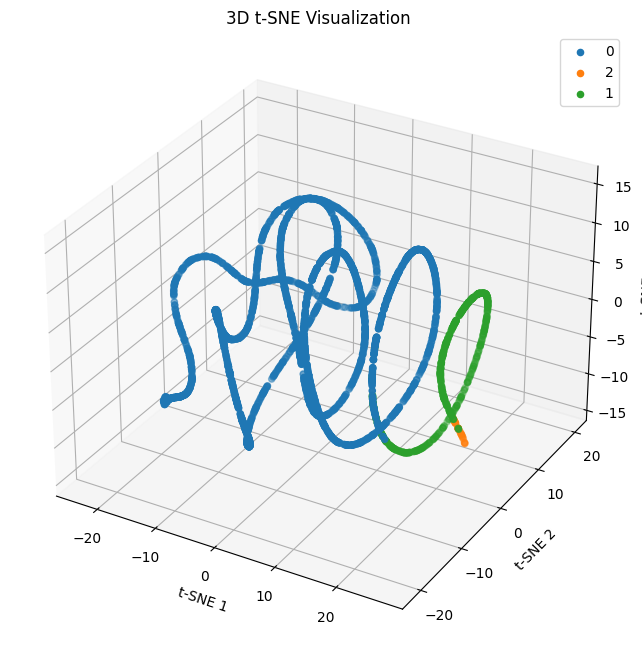

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'batch_size', 'all_parameters', 'all_activations']])

# Create a new DataFrame for the t-SNE results (3 components)
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = df['memory_usage_label']

# Plot the results in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'], label=label)

# Set plot title and labels
ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# Add legend
plt.legend()

# Show the plot
plt.show()

# PCA

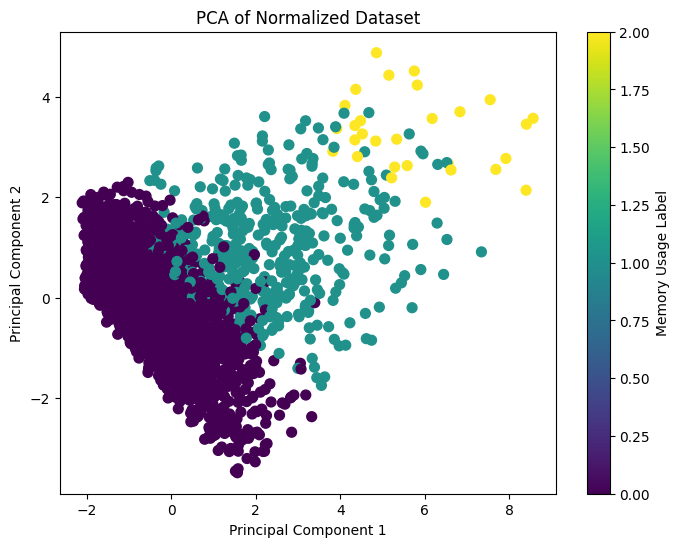

PCA Components:
[[ 0.44067604  0.03027999  0.50930903  0.58865466  0.34302171  0.28457897
   0.0176643   0.00408001]
 [-0.38158215  0.03063818  0.46486644  0.29545529 -0.3360849  -0.43494458
  -0.33408217  0.36921672]]
Explained variance ratio:
[0.29308936 0.15956662]


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # Import for normalization

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']]  # Input features
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar(label='Memory Usage Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Normalized Dataset')

# Show the plot
plt.show()

components = pca.components_

# Get the explained variance ratio for each component (optional, to know how much variance each component explains)
explained_variance = pca.explained_variance_ratio_

# Show the components (each row corresponds to a principal component, each column corresponds to the original feature)
print("PCA Components:")
print(components)

# Show the explained variance ratio for each component
print("Explained variance ratio:")
print(explained_variance)

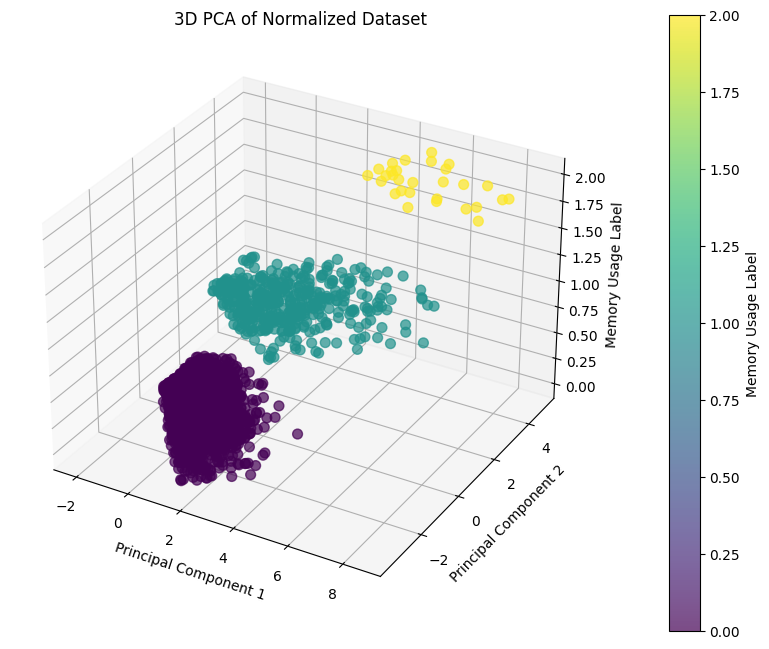

PCA Components:
[[ 0.44067604  0.03027999  0.50930903  0.58865466  0.34302171  0.28457897
   0.0176643   0.00408001]
 [-0.38158215  0.03063818  0.46486644  0.29545529 -0.3360849  -0.43494458
  -0.33408217  0.36921672]
 [-0.21480173  0.07045509  0.25919047  0.15753465 -0.19160806 -0.26384601
   0.62506533 -0.59988699]]
Explained Variance Ratio:
[0.29308936 0.15956662 0.15253431]


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']]  # Input features
y = df['memory_usage_label']  # Output label for coloring

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=3)  # Change to 3 components for 3D plotting
X_pca = pca.fit_transform(X_normalized)

# Plotting the PCA-reduced data in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], y, c=y, cmap='viridis', s=50, alpha=0.7)

# Labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Memory Usage Label')
ax.set_title('3D PCA of Normalized Dataset')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Memory Usage Label')

# Show the plot
plt.show()

# Retrieve and display PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained Variance Ratio:")
print(explained_variance)


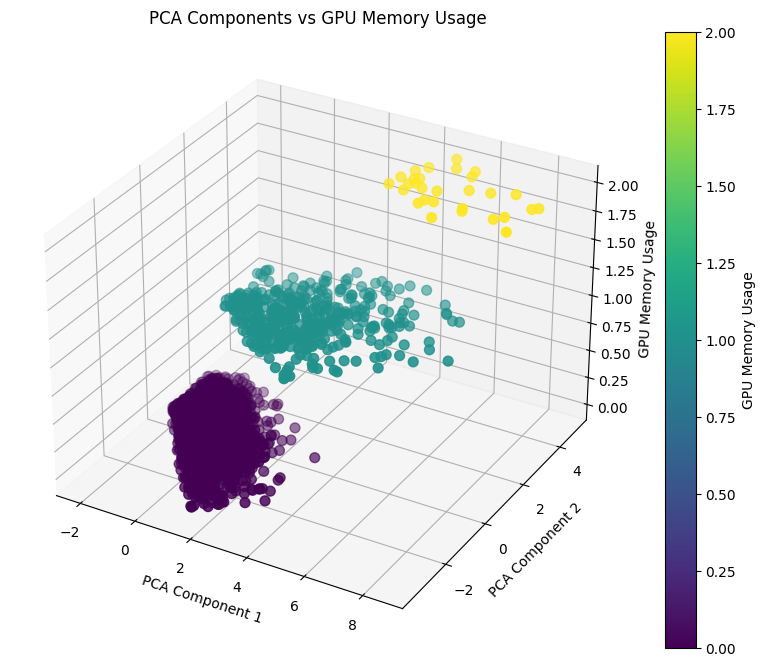

PCA Components:
[[ 0.44067604  0.03027999  0.50930903  0.58865466  0.34302171  0.28457897
   0.0176643   0.00408001]
 [-0.38158215  0.03063818  0.46486644  0.29545529 -0.3360849  -0.43494458
  -0.33408217  0.36921672]]
Explained variance ratio:
[0.29308936 0.15956662]


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']]  # Input features
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Plotting the PCA-reduced data with GPU memory usage as z-axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca1, pca2, y, c=y, cmap='viridis', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('PCA Components vs GPU Memory Usage')

# Color bar
cbar = plt.colorbar(scatter, ax=ax, label='GPU Memory Usage')
plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)


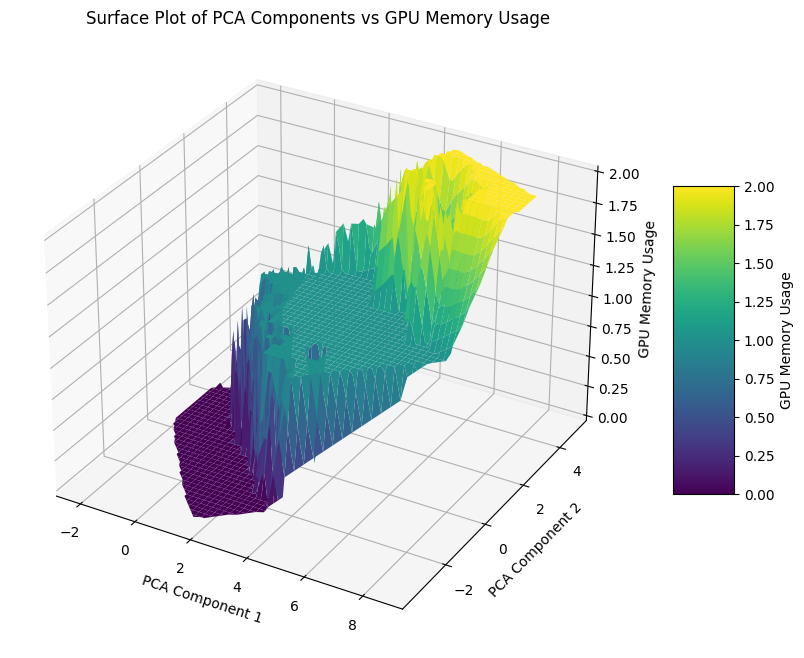

PCA Components:
[[ 0.44067604  0.03027999  0.50930903  0.58865466  0.34302171  0.28457897
   0.0176643   0.00408001]
 [-0.38158215  0.03063818  0.46486644  0.29545529 -0.3360849  -0.43494458
  -0.33408217  0.36921672]]
Explained variance ratio:
[0.29308936 0.15956662]


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

# Example DataFrame columns: 'layers', 'batch_size', 'all_parameters', 'all_activations', 'memory_usage_label'
# Assuming you have a pandas DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from a file

# Prepare data
X = df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']]  # Input features
y = df['memory_usage_label']  # Actual GPU memory usage

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1 = X_pca[:, 0]
pca2 = X_pca[:, 1]

# Create grid for surface plot
pca1_grid, pca2_grid = np.meshgrid(np.linspace(pca1.min(), pca1.max(), 100),
                                   np.linspace(pca2.min(), pca2.max(), 100))

# Interpolate to fit the GPU memory usage on the grid
memory_usage_grid = griddata((pca1, pca2), y, (pca1_grid, pca2_grid), method='linear')

# Plotting the PCA-reduced data with GPU memory usage as a surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(pca1_grid, pca2_grid, memory_usage_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('GPU Memory Usage')
ax.set_title('Surface Plot of PCA Components vs GPU Memory Usage')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('GPU Memory Usage')

plt.show()

# Output PCA components and explained variance ratio
components = pca.components_
explained_variance = pca.explained_variance_ratio_

print("PCA Components:")
print(components)

print("Explained variance ratio:")
print(explained_variance)

# regression model

In [29]:
columns_to_normalize = ['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler and transform the data
df_normalized_reg = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)

# no normalization
# df_normalized = df

In [ ]:
from sklearn.model_selection import train_test_split
x_train_reg, x_temp_reg, y_train_reg, y_temp_reg = train_test_split(
    df_normalized_reg[['layers', 'batch_size', 'all_parameters', 'all_activations']].values, df_normalized_reg['real_memory_usage'].values, test_size=0.3, random_state=42)

x_test_reg, x_val_reg, y_test_reg, y_val_reg = train_test_split(
    x_temp_reg, y_temp_reg, test_size=0.66, random_state=42)

print('total data size: ', len(df_normalized))
print(f"train size {len(x_train_reg)}, val size: {len(x_val_reg)}, test size: {len(x_test_reg)}")

total data size:  3000
train size 2100, val size: 594, test size: 306


In [ ]:
train_dataloader_reg = DataLoader(CustomDataset(x_train_reg, y_train_reg), 64, num_workers=2, shuffle=True)
val_dataloader_reg = DataLoader(CustomDataset(x_val_reg, y_val_reg), 64, num_workers=2)
test_dataloader_reg = DataLoader(CustomDataset(x_test_reg, y_test_reg),1, num_workers=1)
x, y = next(iter(train_dataloader_reg))
print(f"input shape: {x.shape}, output shape: {y.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


input shape: torch.Size([64, 4]), output shape: torch.Size([64])


In [ ]:
class regression_gpu_usage(pl.LightningModule):
    def __init__(self):
        super(regression_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=4, output_features=1, base_features=4)
        # self.criterion = nn.MSELoss()
        self.criterion = nn.L1Loss()
        # self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        # y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.0001)

        # # Use a scheduler that doesn't require setting the learning rate explicitly
        # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         'monitor': 'val_loss',
        #         'frequency': 1
        #     }
        # }
        return optimizer



In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
# logger = TensorBoardLogger("logs")
# Create a checkpoint callback

# checkpoint_callback = ModelCheckpoint(
#     dirpath=config['model_save_dir'],
#     filename=f"{config['modality_type']}",
#     save_top_k=1,
#     verbose=True,
#     monitor='val_loss',
#     mode='min'
# )

# Initialize the model
regression_model = regression_gpu_usage()
regression_model.train()
# Initialize the trainer with mixed precision (AMP) and early stopping
trainer = pl.Trainer(
    # logger = logger,
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(regression_model, train_dataloaders=train_dataloader_reg, val_dataloaders=val_dataloader_reg)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | FC_base | 89     | train
1 | criterion | L1Loss  | 0      | train
----------------------------------------------
89        Trainable params
0         Non-trainable params
89        Total params
0.000     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.571


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.570


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.566


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.560


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.558


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.553


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.550


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.547


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.544


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.543


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.541


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.540


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.539


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.538


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.536


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.536


In [ ]:
regression_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader_reg:
        pred = regression_model(test_data[0])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(pred.item())
        print(f"prediction: {pred.item()}, gt: {test_data[1].item()}")

plt.figure(figsize=(15, 3))
plt.scatter(range(1, len(pred_list) + 1), pred_list, label="predicted")
plt.scatter(range(1, len(gt) + 1), gt, label="actual value")
plt.legend()